#### <a id="segundo"></a>
## 2. PARTE 2 TAREA: Estimación de edad de personas
El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.

<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />

Se trabajará con datos (imágenes) con el **objetivo** de predecir la **edad** (*target value*) de la persona presente en la imagen. Los datos corresponden a 3640 imágenes de rostros de personas extraídos de la plataforma Flickr
```


In [0]:
#importando librerías requeridas inicialmente

import pandas as pd
import numpy as np

In [0]:
#importando MAPE para su utilización como métrica de evaluación

import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
#datos para entrenamiento y test

import scipy.io as sio
mat_file = sio.loadmat("eventrain.mat")
mat_file_test = sio.loadmat("eventest.mat")

In [0]:
#Se usarán los siguientes atributos para el entrenamiento del modelo

data = mat_file["trcoll"][0][0] # is "tecoll" for training set
age_true = data[1] #target
genClass = data[2] # gender class male or female
genFeat = data[0]   # Contextual features
ffcoefs = data[3]   # Fisherface space
faceGist = data[4]  # GIST features

In [0]:
#Se usarán los siguientes atributos para el testing del modelo

data = mat_file_test["tecoll"][0][0] # is "tecoll" for testing set
age_true_test = data[1] #target
genClass_test = data[2] # gender class male or female
genFeat_test = data[0]   # Contextual features
ffcoefs_test = data[3]   # Fisherface space
faceGist_test = data[4]  # GIST features

In [0]:
# Conjunto de prueba

#Acá se genera una concatenación de los atributos para trabajar con una gran matriz.

X_test0 = np.concatenate((genClass_test, genFeat_test, ffcoefs_test, faceGist_test), axis = 1)
Y_test0 = age_true_test[:,0]

In [0]:
# Conjunto de entrenamiento

#Acá se genera una concatenación de los atributos para trabajar con una gran matriz.

X_train0 = np.concatenate((genClass, genFeat, ffcoefs, faceGist), axis = 1)
Y_train0 = age_true[:,0]

In [38]:
X_train0.shape

(3500, 652)

In [39]:
Y_train0.shape

(3500,)

#### Uso de métodos de selección de atributos para el Modelo

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

In [0]:
# Aplicando el algoritmo univariante de prueba F para selecciòn de atributos

k = 3  # número de atributos a seleccionar
selector = SelectKBest(f_classif, k=k).fit(X_train0, Y_train0)


In [0]:
X_train_new = selector.transform(X_train0)

In [43]:
print(X_train_new)

[[34.          1.04286927  0.11850787]
 [12.          1.04286927 -7.8452211 ]
 [35.          1.05996663  0.49773306]
 ...
 [39.          0.82285398  1.6561822 ]
 [81.          0.81634195  3.33111238]
 [61.          0.8557424   3.40514165]]


Se puede observar que se han seleccionado 3 atributos: genFeat (Contextual features), ffcoef (fisherface space) y faceGist (GIST features) por lo tanto se trabajará con ellos solamente en el modelo.

In [0]:
# Conjunto de prueba FINAL solo con los 3 atributos seleccionados en la prueba anterior.

#Acá se genera una concatenación de los atributos para trabajar con una gran matriz.

X_test = np.concatenate((genFeat_test, ffcoefs_test, faceGist_test), axis = 1)
Y_test = age_true_test[:,0]


In [0]:
# Conjunto de entrenamiento FINAL solo con los 3 atributos seleccionados en la prueba anterior.

#Acá se genera una concatenación de los atributos para trabajar con una gran matriz.

X_train = np.concatenate((genFeat, ffcoefs, faceGist), axis = 1)
Y_train = age_true[:,0]


### A continuación se prueba con otro modelo solamente para ver como se está comportando (algo totalmente opcional) se usa Random Forest para esto:

In [0]:
#Uso opcional de prueba de Random Forest.

from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor(n_jobs=-1)

In [47]:
#Entrenamiento con Random Forest 

rf_clf.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [48]:
#MAPE en Random Forest

mean_absolute_percentage_error(Y_train, rf_clf.predict(X_train))

84.55979463785515

In [49]:
#MAPE en Random Forest 

mean_absolute_percentage_error(Y_test, rf_clf.predict(X_test))

207.83872529011603

### A continuación se hará uso opcinal de redes feed forward (redes neuronales densas en este caso)

In [0]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

In [51]:
X_train.shape[1]

651

In [0]:
#CONSTRUCCION DE LA ARQUITECTURA DE LA RED
#Se usará la funnción de activación relu, que es una de las cuales mejores resultados ha arrojado probando
#Del mismo modo una regularización del Kernel mediante "l2 y un inicializador de este con glorot_uniform.

base_nn = Sequential()
base_nn.add(
    Dense(30, input_dim = X_train.shape[1],
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
         name = 'input_layer')
)

base_nn.add(
    Dense(100,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
          kernel_regularizer = 'l2',
         name = 'hidden_1')
)

base_nn.add(
    Dense(100,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
          kernel_regularizer = 'l2',
         name = 'hidden_2')
)
base_nn.add(
    Dense(100,
         kernel_initializer = 'glorot_uniform',
          kernel_regularizer = 'l2',
         activation = 'relu',
         name = 'hidden_3')
)
base_nn.add(
    Dense(100,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
        kernel_regularizer = 'l2',
         name = 'hidden_4')
)
base_nn.add(
    Dense(100,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
         kernel_regularizer = 'l2',
         name = 'hidden_5')
)

base_nn.add(
    Dense(50,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
         kernel_regularizer = 'l2',
         name = 'hidden_6')
)

base_nn.add(
    Dense(20,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
         name = 'hidden_7')
)
base_nn.add(
    Dense(1,
         kernel_initializer = 'glorot_uniform',
         activation = 'relu',
         name = 'out')
)

In [53]:
base_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 30)                19560     
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               3100      
_________________________________________________________________
hidden_2 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_3 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_4 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_5 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_6 (Dense)             (None, 50)               

In [0]:
from sklearn.model_selection import train_test_split

X_train_2, x_val, Y_train_2, y_val = train_test_split(X_train, Y_train, random_state = 11235813, test_size = .33)

In [0]:
from keras.callbacks import History
history = History()

In [56]:
#Optimizador Adagrad, función de pérdida se usará la métrica de evaluación MAPE
# Se corroboró con varios epochs, dejando 200 finalmente

from keras.optimizers import Adagrad

base_nn.compile(optimizer=Adagrad(), loss = 'MAPE', metrics = ['mse'])
base_nn.fit(X_train_2, Y_train_2, epochs = 200, batch_size = 128, verbose = 0, callbacks=[history], validation_data=(x_val, y_val))

In [57]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

In [0]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

Final loss (Validation): 102.0312


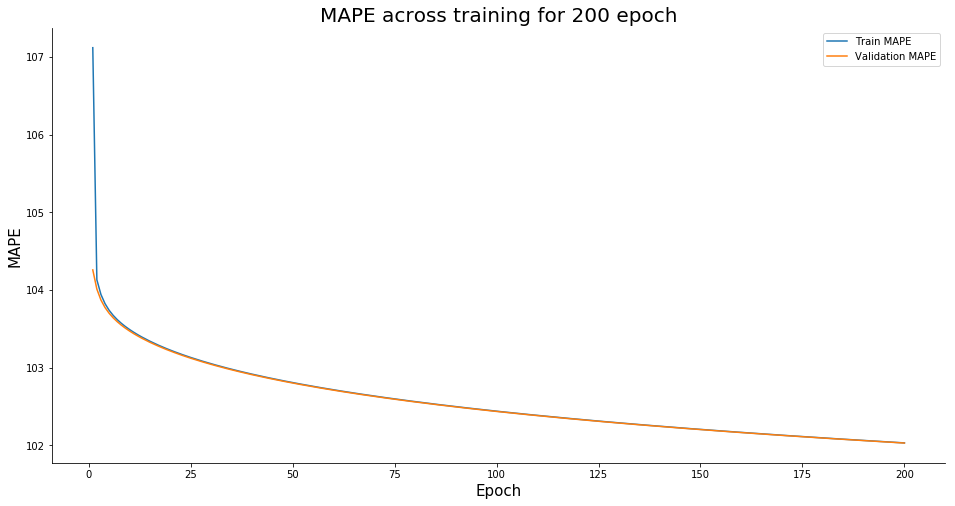

In [59]:
import matplotlib.pyplot as plt
import seaborn as sn
print('Final loss (Validation): {0}'.format(loss_val[-1].round(4)))

fig,_ = plt.subplots(figsize = (16,8))
plt.title('MAPE across training for 200 epoch', size = 20)
plt.xlabel('Epoch', size = 15)
plt.ylabel('MAPE', size = 15)
plt.plot(range(1,201), loss_train, '-', label = 'Train MAPE');
plt.plot(range(1,201), loss_val, '-', label = 'Validation MAPE');
plt.legend();
sn.despine()

In [60]:
#USO OPCIONAL PARA CORROBORAR error

from sklearn.metrics import mean_absolute_error

mean_absolute_error(Y_test, base_nn.predict(X_test))

26.571428

In [61]:
#MAPE SOLICITADO PARA LA RED NEURONAL

mean_absolute_percentage_error(Y_test, base_nn.predict(X_test))


100.0

In [62]:
#RECORDANDO MAPE CON RANDOM FOREST PARA COMPARACIÓN CON LA RED NEURONAL

mean_absolute_percentage_error(Y_test, rf_clf.predict(X_test))

207.83872529011603

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


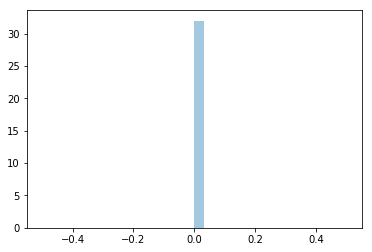

In [63]:
#Gráfico de distibución

sn.distplot(base_nn.predict(X_test))

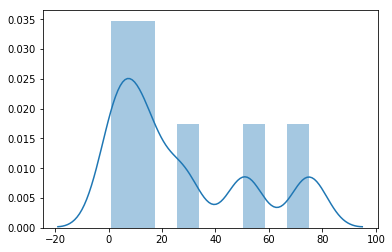

In [64]:
#Gráfico de distibución

sn.distplot(Y_test)

### A continuación se hará uso de Regresión Lineal de mı́nimos cuadrados básica final.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [66]:
#Modelo SIN estandarización de datos

model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


In [68]:
#MAPE SOLICITADO PARA LA REGRESIÓN SIN estandarizar datos:

mean_absolute_percentage_error(Y_test, model.predict(X_test))


266.5498713712991

In [0]:
#Modelo CON estandarización de datos

std = StandardScaler()
std.fit(X_train)
Xstd_train = std.transform(X_train) 
Xstd_test = std.transform(X_test)


In [70]:
model2 = LinearRegression(fit_intercept=True)
model2.fit(Xstd_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
pred_train2 = model2.predict(Xstd_train)
pred_test2 = model2.predict(Xstd_test)

In [72]:
#MAPE SOLICITADO PARA LA REGRESIÓN CON estandarizar datos:

mean_absolute_percentage_error(Y_test, model2.predict(Xstd_test))


266.5498713727641

## Algunas consideraciones finales:


### Se encuentran mejores ajustes mediante el uso de la red neuronal con la configuración dada. Se probaron distintas configuraciones, del mismo modo distintos optimizadores y funciones de activación. El uso de la combinación del regularizador l2 y del inicializador "glorot_uniform" para el kernel mejoraron considerablemente el resultado final, logrando una mejor uniformidad de las muestras, lo que generó una disminución del MAPE final. 

### Cabe señalar que el uso de la Red Neuronal densa y la regresión Random Forest han sido opcionales para corroborar otros MAPE con los mismos datos que fueron seleccionados inicialmente. Finalmente se genera una Regresión Lineal de Mínimos Cuadrados básica como es solicitado y se cálcula el error final.

### Arquitectura de la red neuronal opcional usada

#### El uso de la famosa función de activación ReLU usada en la Arquitectura elegida para la red se debe a que cuando procesamos una imagen, cada capa de convolución debe capturar algún patrón en la imagen y pasarla en la siguiente capa de convolución. Los valores negativos no son importantes en el procesamiento de imágenes y, por lo tanto, se establecen en 0. Pero los valores positivos después de la convolución deben pasar a la siguiente capa. Es por eso que Relu se utiliza bastante como una función de activación en redes neuronales, más aún cuando se trabaja con patrones en imágenes.

#### ReLU (x) = 0 si x = 0.

#### Del mismo modo el uso de inicializador del nucleo es importante ya que la red neuronal necesita comenzar con algunos pesos y luego actualizarlos iterativamente a mejores valores. El t kernel_initializer es un término que se utiliza como función para inicializar los pesos y una de las ampliamente utilizadas es la glorot_uniform.

#### Se uso además unn regularizador para evitar el sobreajuste que se encontró en algún momento al no usar este regularizador, L1 y L2 son los tipos más comunes de regularización. Estos actualizan la función de costo general al agregar otro término conocido como el término de regularización. Debido a la adición de este término de regularización, los valores de las matrices de peso disminuyen porque supone que una red neuronal con matrices de peso más pequeñas conduce a modelos más simples. Por lo tanto, también reducirá el sobreajuste en gran medida.

#### Función de costo = Pérdida + Término de regularización

### MAPES finales de los 3 modelos:

#### MAPE Red Neuronal Densa = 100
#### MAPE Random Forest = 208
### MAPE Regresión Lineal = 266

#### La estandarización de los datos de entrada para este caso no aportó una mejoría sustancial.

** La red no ha sido ejecutada en el envío para no sobrecargar tanto el Notebook, puede ser ejecutada para corroborar resultados, del mismo modo los gráficos generados.

